In [1]:
import pandas as pd
pd.set_option('display.max_rows', 15)
import wrds
import numpy as np
from scipy.stats.mstats import winsorize
from scipy import stats
import statsmodels.api as sm
import seaborn as sns; sns.set()
import matplotlib as mpl
import matplotlib.pyplot as plt


In [2]:
conn = wrds.Connection(wrds_username="kaiyuw")
conn.create_pgpass_file() # then you don't need to enter password next time.
conn.close()

conn = wrds.Connection(wrds_username='kaiyuw')

Loading library list...
Done
Enter your WRDS username [kaiyuwang]:kaiyuw
Enter your password:········
Loading library list...
Done


In [3]:
act = conn.raw_sql("""
                      select gvkey, datadate,fyear,sich,at,oiadp,act,che,lct,dlc,txp,dp,exchg
	                  from compa.funda where (consol='C' and indfmt='INDL' and datafmt='STD' and popsrc='D') and
fyear<1992 and fyear>1960 and (exchg =11 or exchg =12)
                     """) 

In [4]:
company = conn.raw_sql("""
                      select gvkey, sic
	                  from compa.company
                     """) 
act=pd.merge(act,company,on=['gvkey'])

In [5]:
# act=act.drop_duplicates(subset=['gvkey','fyear'])
act['sic1']=np.where(act['sich']>0,act['sich']>0,act['sic'])
act=act.drop(['sich','sic'],axis=1)
act['sic1']=act['sic1'].astype(int)
act['sic1']=act['sic1'].floordiv(other = 100)

In [6]:
act

,gvkey,datadate,fyear,at,oiadp,act,che,lct,dlc,txp,dp,exchg,sic1
0,001000,1961-12-31,1961.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,30
1,001000,1962-12-31,1962.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.040,12.0,30
2,001000,1963-12-31,1963.0,NaN,0.000,0.408,NaN,0.322,NaN,0.000,0.046,12.0,30
3,001000,1964-12-31,1964.0,1.416,0.074,0.718,0.269,0.267,0.088,0.007,0.053,12.0,30
4,001000,1965-12-31,1965.0,2.310,-0.242,0.725,0.031,0.623,0.300,0.000,0.082,12.0,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...
68136,184740,1982-12-31,1982.0,152.993,12.876,15.097,2.649,37.444,18.681,0.000,17.124,12.0,13
68137,184740,1975-12-31,1975.0,4.377,0.294,0.758,0.197,0.565,0.135,0.000,0.233,12.0,13
68138,184740,1983-12-31,1983.0,114.368,12.728,15.688,4.704,27.519,12.501,0.000,15.275,12.0,13
68139,184740,1974-12-31,1974.0,3.402,0.260,0.353,0.039,0.337,0.213,0.000,0.157,12.0,13


In [7]:
len(act['sic1'].unique())

70

In [8]:
data = ''
# act=act.drop_duplicates(subset=['gvkey','fyear'])
temp=act.copy()
at_lag= act[['gvkey','fyear','at']].copy() # you can use shift, but shift gives wrong lag variables when there are missing years. 
at_lag['fyear']=at_lag['fyear']+1
at_lag=at_lag.rename(columns={'at':'at_lag1'})

data=pd.merge(temp, at_lag, how='left', on=['gvkey','fyear'])

In [9]:
data

,gvkey,datadate,fyear,at,oiadp,act,che,lct,dlc,txp,dp,exchg,sic1,at_lag1
0,001000,1961-12-31,1961.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,30,NaN
1,001000,1962-12-31,1962.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.040,12.0,30,NaN
2,001000,1963-12-31,1963.0,NaN,0.000,0.408,NaN,0.322,NaN,0.000,0.046,12.0,30,NaN
3,001000,1964-12-31,1964.0,1.416,0.074,0.718,0.269,0.267,0.088,0.007,0.053,12.0,30,NaN
4,001000,1965-12-31,1965.0,2.310,-0.242,0.725,0.031,0.623,0.300,0.000,0.082,12.0,30,1.416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68139,184740,1982-12-31,1982.0,152.993,12.876,15.097,2.649,37.444,18.681,0.000,17.124,12.0,13,177.177
68140,184740,1975-12-31,1975.0,4.377,0.294,0.758,0.197,0.565,0.135,0.000,0.233,12.0,13,3.402
68141,184740,1983-12-31,1983.0,114.368,12.728,15.688,4.704,27.519,12.501,0.000,15.275,12.0,13,152.993
68142,184740,1974-12-31,1974.0,3.402,0.260,0.353,0.039,0.337,0.213,0.000,0.157,12.0,13,NaN


In [10]:
actrual_lag= act[['gvkey','fyear','act','che','lct','dlc','txp','dp']].copy() # you can use shift, but shift gives wrong lag variables when there are missing years. 
actrual_lag['fyear']=actrual_lag['fyear']+1
actrual_lag=actrual_lag.rename(columns={'act':'act_lag1','che':'che_lag1','lct':'lct_lag1','dlc':'dlc_lag1','txp':'txp_lag1','dp':'dp_lag1',})

data=pd.merge(data, actrual_lag, how='left', on=['gvkey','fyear'])

In [11]:
data = data.dropna()
len(data['sic1'].unique())

68

In [12]:
data['Earnings'] = data['oiadp']/((data['at']+data['at_lag1'])/2)
data['ca']=data['act']-data['act_lag1']
data['cash']=data['che']-data['che_lag1']
data['cl']=data['lct']-data['lct_lag1']
data['std']=data['dlc']-data['dlc_lag1']
data['tp']=data['txp']-data['txp_lag1']

In [13]:
data['Accruals'] = ((data['ca']-data['cash'])-(data['cl']-data['std']-data['tp'])-data['dp'])/((data['at']+data['at_lag1'])/2)
data['CashFlow']=data['Earnings']-data['Accruals']
# data[['gvkey','fyear','datadate','Earnings','Accruals','CashFlow']]

In [14]:
data['sic1'].unique()

array([30, 50,  0, 37, 78, 39, 28, 34, 23, 49, 73, 67, 48, 35, 36, 26, 27,
       75, 59, 22, 51, 13, 65, 38, 10, 45, 54, 33, 64, 44, 63, 20, 99, 56,
       53, 32, 15, 61,  1, 31, 80, 70, 25, 29, 72, 87, 42, 40, 21, 62, 79,
       16, 12, 57, 58, 24, 52, 14, 82, 60, 17, 47, 55, 41,  7, 76, 46,  8])

In [15]:
data_earnings= data[['gvkey','fyear','datadate','sic1','Earnings','Accruals','CashFlow']].copy()
data_earnings = data_earnings.dropna()
data_earnings=data_earnings.drop_duplicates(subset=['gvkey','fyear'])
data_earnings
data_earnings['sic1'].unique()

array([30, 50,  0, 37, 78, 39, 28, 34, 23, 49, 73, 67, 48, 35, 36, 26, 27,
       75, 59, 22, 51, 13, 65, 38, 10, 45, 54, 33, 64, 44, 63, 20, 99, 56,
       53, 32, 15, 61,  1, 31, 80, 70, 25, 29, 72, 87, 42, 40, 21, 62, 79,
       16, 12, 57, 58, 24, 52, 14, 82, 60, 17, 47, 55, 41,  7, 76, 46,  8])

In [16]:
for year in data_earnings.groupby(['fyear']):
    data_earnings['AccuralDecile'] = pd.qcut(data_earnings['Accruals'],10,labels=[1,2,3,4,5,6,7,8,9,10])
    data_earnings['EarningsDecile'] = pd.qcut(data_earnings['Earnings'],10,labels=[1,2,3,4,5,6,7,8,9,10])
    data_earnings['CashFlowDecile'] = pd.qcut(data_earnings['CashFlow'],10,labels=[1,2,3,4,5,6,7,8,9,10])

In [17]:
for_plot = data_earnings.copy()  

In [18]:
data_earnings =data_earnings.reindex()
for_plot = data_earnings.copy() 

In [19]:
data_earnings['sic1'].unique()

array([30, 50,  0, 37, 78, 39, 28, 34, 23, 49, 73, 67, 48, 35, 36, 26, 27,
       75, 59, 22, 51, 13, 65, 38, 10, 45, 54, 33, 64, 44, 63, 20, 99, 56,
       53, 32, 15, 61,  1, 31, 80, 70, 25, 29, 72, 87, 42, 40, 21, 62, 79,
       16, 12, 57, 58, 24, 52, 14, 82, 60, 17, 47, 55, 41,  7, 76, 46,  8])

In [20]:
for_plot

,gvkey,fyear,datadate,sic1,Earnings,Accruals,CashFlow,AccuralDecile,EarningsDecile,CashFlowDecile
4,001000,1965.0,1965-12-31,30,-0.129898,0.006441,-0.136339,7,1,1
5,001000,1966.0,1966-12-31,30,0.147679,0.035443,0.112236,9,7,4
6,001000,1967.0,1967-12-31,30,0.001228,-0.058535,0.059763,3,1,2
7,001000,1968.0,1968-12-31,30,0.179757,-0.088804,0.268561,2,8,10
8,001000,1969.0,1969-12-31,30,0.227002,0.529999,-0.302997,10,9,1
...,...,...,...,...,...,...,...,...,...,...
68144,184740,1981.0,1981-12-31,13,0.049930,-0.185222,0.235152,1,2,9
68145,184740,1982.0,1982-12-31,13,0.077996,-0.043959,0.121955,4,4,5
68146,184740,1975.0,1975-12-31,13,0.075588,-0.075074,0.150662,3,4,6
68147,184740,1983.0,1983-12-31,13,0.095212,-0.097202,0.192414,2,5,8


In [21]:
data_earnings.to_csv("data_earnings3deciles.csv") # locally backup 

# Replicate Table1

In [22]:
AccuralMean = data_earnings.groupby(data_earnings['AccuralDecile'])['Accruals'].mean()
AccuralMedian = data_earnings.groupby(data_earnings['AccuralDecile'])['Accruals'].median()
CashFlowMean = data_earnings.groupby(data_earnings['AccuralDecile'])['CashFlow'].mean()
CashFlowMedian = data_earnings.groupby(data_earnings['AccuralDecile'])['CashFlow'].median()
EarningsMean = data_earnings.groupby(data_earnings['AccuralDecile'])['Earnings'].mean()
EarningsMedian = data_earnings.groupby(data_earnings['AccuralDecile'])['Earnings'].median()
p = pd.DataFrame(list(zip(AccuralMean,AccuralMedian,CashFlowMean,CashFlowMedian,EarningsMean,EarningsMedian)))
p.columns=["AccuralMean", "AccuralMedian","CashFlowMean",'CashFlowMedian','EarningsMean','EarningsMedian']
p.index += 1 
p=p.transpose()
p

,1,2,3,4,5,6,7,8,9,10
AccuralMean,-0.182637,-0.090958,-0.065080,-0.047578,-0.033138,-0.019500,-0.003138,0.019278,0.055439,0.173482
AccuralMedian,-0.148517,-0.089971,-0.064819,-0.047527,-0.033077,-0.019626,-0.003319,0.018788,0.053591,0.135326
CashFlowMean,0.236921,0.185730,0.169757,0.157287,0.144549,0.135098,0.125996,0.116574,0.092009,-0.009289
CashFlowMedian,0.224613,0.184128,0.164659,0.152701,0.136065,0.122805,0.116101,0.109371,0.083164,0.001790
EarningsMean,0.054284,0.094771,0.104678,0.109709,0.111411,0.115598,0.122858,0.135852,0.147448,0.164194
EarningsMedian,0.061495,0.093624,0.100472,0.105245,0.102556,0.103105,0.113328,0.128142,0.137704,0.149915


In [23]:
data_earnings = for_plot.copy()
# print(len(data_earnings['sic1'].unique()))
earnings_lag= data_earnings[['gvkey','fyear','Earnings']].copy() # you can use shift, but shift gives wrong lag variables when there are missing years. 
earnings_lag['fyear']=earnings_lag['fyear']-1
earnings_lag=earnings_lag.rename(columns={'Earnings':'Earnings_lead1'})
# earnings_lag['Earnings_lead1']=earnings_lag['Earnings_lead1'].astype(float)
data_earnings=pd.merge(data_earnings, earnings_lag, how='left', on=['gvkey','fyear'])
data_earnings=data_earnings.dropna()
print(len(data_earnings['sic1'].unique()))
# data_earnings

68


In [24]:
# data_earnings=data_earnings.dropna()
len(data_earnings['sic1'].unique())

68

In [25]:
# data_earnings['Earnings']=data_earnings['Earnings'].astype(float)
# data_earnings['Earnings_lead1']=data_earnings['Earnings_lead1'].astype(float)
# data_earnings['CashFlow']=data_earnings['CashFlow'].astype(float)
# data_earnings['Accruals']=data_earnings['Accruals'].astype(float)
# data_earnings.info()

# Regression On Earnings

In [26]:
x = sm.add_constant(data_earnings['Earnings'])
regression_on_earnings =sm.OLS(data_earnings['Earnings_lead1'],x).fit()

/Users/kaiyuwang/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [27]:
print(regression_on_earnings.params)
x_result=pd.DataFrame(regression_on_earnings.params)
# x_result

const       0.021306
Earnings    0.797831
dtype: float64


In [28]:
print(regression_on_earnings.summary())

                            OLS Regression Results                            
Dep. Variable:         Earnings_lead1   R-squared:                       0.688
Model:                            OLS   Adj. R-squared:                  0.688
Method:                 Least Squares   F-statistic:                 8.815e+04
Date:                Thu, 20 Feb 2020   Prob (F-statistic):               0.00
Time:                        20:04:44   Log-Likelihood:                 45890.
No. Observations:               39947   AIC:                        -9.178e+04
Df Residuals:                   39945   BIC:                        -9.176e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0213      0.000     42.666      0.0

In [29]:
list1 = data_earnings['sic1'].unique()
regression_result_on_constant_industry=[]
regression_result_on_earnings_industry=[]
for list_index in list1:
    data_temp = data_earnings[data_earnings['sic1']==list_index]
    x = sm.add_constant(data_temp['Earnings'])
    industry =sm.OLS(data_temp['Earnings_lead1'],x).fit()
#     print(industry.params)
    if len(industry.params.values[0:]) == 2:
        constant= industry.params.values[0:][0]
        earnings =industry.params.values[0:][1]
    if len(industry.params.values[0:]) == 1:
        constant= 0
        earnings =industry.params.values[0:][0]
    regression_result_on_constant_industry.append(constant)
    regression_result_on_earnings_industry.append(earnings)
#     print("Industry Code ",list_index,"'s \tconstant",constant,"\tcoefficient",earnings)
earnings_regression_table = pd.DataFrame(list(zip(list1,regression_result_on_constant_industry,regression_result_on_earnings_industry)))
earnings_regression_table .columns=["Industry Code","const","Earnings"]
earnings_regression_table 

,Industry Code,const,Earnings
0,30,0.036253,0.712025
1,50,0.022335,0.768763
2,0,0.015449,0.787559
3,37,0.039894,0.629418
4,78,0.043514,0.563149
...,...,...,...
63,41,0.068181,0.599728
64,7,0.019823,0.775246
65,76,0.000000,0.716988
66,46,0.000000,0.439566


In [30]:
earnings_regression_table[['const','Earnings']].describe().transpose()
tem = earnings_regression_table[['const','Earnings']].describe().transpose()
median = pd.DataFrame(earnings_regression_table[['const','Earnings']].median())
earnings_regression_table[['const','Earnings']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
const,68.0,0.025320,0.015032,-0.003740,0.015631,0.024936,0.032891,0.069448
Earnings,68.0,0.728885,0.194641,-0.504283,0.678889,0.744498,0.805297,1.189859


In [31]:
x_results = pd.concat([x_result,tem[['mean','25%']],median,tem['75%']],axis =1)
x_results .columns=["Pooled","Mean","Q1","Median","Q3"]
x_results

,Pooled,Mean,Q1,Median,Q3
const,0.021306,0.025320,0.015631,0.024936,0.032891
Earnings,0.797831,0.728885,0.678889,0.744498,0.805297


# Regression On Accural & Cashflow

In [32]:
x = sm.add_constant(data_earnings[['Accruals','CashFlow']])
regression_on_accural_cashflow =sm.OLS(data_earnings['Earnings_lead1'],x).fit()

In [33]:
print(regression_on_accural_cashflow.params)
x_result=pd.DataFrame(regression_on_accural_cashflow.params)

const       0.019800
Accruals    0.758692
CashFlow    0.803987
dtype: float64


In [34]:
print(regression_on_accural_cashflow.summary())

                            OLS Regression Results                            
Dep. Variable:         Earnings_lead1   R-squared:                       0.689
Model:                            OLS   Adj. R-squared:                  0.689
Method:                 Least Squares   F-statistic:                 4.432e+04
Date:                Thu, 20 Feb 2020   Prob (F-statistic):               0.00
Time:                        20:04:45   Log-Likelihood:                 45967.
No. Observations:               39947   AIC:                        -9.193e+04
Df Residuals:                   39944   BIC:                        -9.190e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0198      0.001     38.592      0.0

In [35]:
list1 = data_earnings['sic1'].unique()
regression_result_on_constant_industry=[]
regression_result_on_accurals_industry=[]
regression_result_on_cashflow_industry=[]
for list_index in list1:
    data_temp = data_earnings[data_earnings['sic1']==list_index]
    x = sm.add_constant(data_temp[['Accruals','CashFlow']])
    industry =sm.OLS(data_temp['Earnings_lead1'],x).fit()
#     print(industry.params)
    if len(industry.params.values[0:]) == 3:
        constant= industry.params.values[0:][0]
        accrual_coef =industry.params.values[0:][1]
        cashflow_coef= industry.params.values[0:][2]
    if len(industry.params.values[0:]) == 2:
        constant= 0
        accrual_coef =industry.params.values[0:][0]
        cashflow_coef= industry.params.values[0:][1]
    regression_result_on_constant_industry.append(constant)
    regression_result_on_accurals_industry.append(accrual_coef)
    regression_result_on_cashflow_industry.append(cashflow_coef)
earnings_regression_table = pd.DataFrame(list(zip(list1,regression_result_on_constant_industry,regression_result_on_accurals_industry,regression_result_on_cashflow_industry)))
earnings_regression_table.columns=["Industry Code","const","Accruals","CashFlow"]
earnings_regression_table 

,Industry Code,const,Accruals,CashFlow
0,30,0.035034,0.699738,0.719445
1,50,0.022455,0.787957,0.760079
2,0,0.013151,0.738984,0.792292
3,37,0.037157,0.586144,0.647328
4,78,0.036871,0.508778,0.592889
...,...,...,...,...
63,41,0.058410,0.588688,0.642961
64,7,0.007214,0.643368,0.863496
65,76,0.000000,0.815379,0.578246
66,46,0.000000,0.388934,0.480546


In [36]:
earnings_regression_table[["const","Accruals","CashFlow"]].describe().transpose()
tem = earnings_regression_table[["const","Accruals","CashFlow"]].describe().transpose()
median = pd.DataFrame(earnings_regression_table[["const","Accruals","CashFlow"]].median())

In [37]:
x_result

,0
const,0.019800
Accruals,0.758692
CashFlow,0.803987


In [38]:
x_results = pd.concat([x_result,tem[['mean','25%']],median,tem['75%']],axis =1)
x_results .columns=["Pooled","Mean","Q1","Median","Q3"]
x_results

,Pooled,Mean,Q1,Median,Q3
const,0.019800,0.022622,0.011225,0.023043,0.030539
Accruals,0.758692,0.662705,0.615340,0.695489,0.780619
CashFlow,0.803987,0.741672,0.707313,0.761664,0.835242


In [39]:
def generate_gap(data, variable,gaplength, lag):
    gap = 1 if lag == 'lag' else -1
    v_name = '_lag' if lag == 'lag' else "_lead"
    temp_data = data[['gvkey','fyear',variable]].copy()
    temp_data['fyear']=temp_data['fyear']+1*gap*gaplength
    temp_data=temp_data.rename(columns={'Earnings':'Earnings'+v_name+str(gaplength)})
    data=pd.merge(data, temp_data, how='left', on=['gvkey','fyear'])
    print("finish merging ",v_name,gaplength,data.shape)
    return data

In [40]:
# data_earnings = pd.read_csv('data_earnings3deciles.csv',header=True)
# data_earnings['Earnings']=data_earnings['Earnings'].astype(float)
# data_earnings

In [41]:
data_earnings = for_plot.copy()

In [42]:
data_earnings = for_plot.copy()
data_earnings = generate_gap(data_earnings,'Earnings',1,"lead")
data_earnings = generate_gap(data_earnings,'Earnings',2,"lead")
data_earnings = generate_gap(data_earnings,'Earnings',3,"lead")
data_earnings = generate_gap(data_earnings,'Earnings',4,"lead")
data_earnings = generate_gap(data_earnings,'Earnings',5,"lead")
data_earnings = generate_gap(data_earnings,'Earnings',1,"lag")
data_earnings = generate_gap(data_earnings,'Earnings',2,"lag")
data_earnings = generate_gap(data_earnings,'Earnings',3,"lag")
data_earnings = generate_gap(data_earnings,'Earnings',4,"lag")
data_earnings = generate_gap(data_earnings,'Earnings',5,"lag")
# data_earnings.dropna()

finish merging  _lead 1 (43386, 11)
finish merging  _lead 2 (43386, 12)
finish merging  _lead 3 (43386, 13)
finish merging  _lead 4 (43386, 14)
finish merging  _lead 5 (43386, 15)
finish merging  _lag 1 (43386, 16)
finish merging  _lag 2 (43386, 17)
finish merging  _lag 3 (43386, 18)
finish merging  _lag 4 (43386, 19)
finish merging  _lag 5 (43386, 20)


In [43]:
Accuraldecile1 = data_earnings[data_earnings['AccuralDecile']==1]
Accuraldecile10 = data_earnings[data_earnings['AccuralDecile']==10]
Earningsdecile1 = data_earnings[data_earnings['EarningsDecile']==1]
Earningsdecile10 = data_earnings[data_earnings['EarningsDecile']==10]
CashFlowdecile1 = data_earnings[data_earnings['CashFlowDecile']==1]
CashFlowdecile10 = data_earnings[data_earnings['CashFlowDecile']==10]

In [44]:
data_earnings
# Accuraldecile1_list = Accuraldecile1[['Earnings_lag5','Earnings_lag4','Earnings_lag3','Earnings_lag2','Earnings_lag1','Earnings','Earnings_lead1','Earnings_lead2','Earnings_lead3','Earnings_lead4','Earnings_lead5']].mean()

,gvkey,fyear,datadate,sic1,Earnings,Accruals,CashFlow,AccuralDecile,EarningsDecile,CashFlowDecile,Earnings_lead1,Earnings_lead2,Earnings_lead3,Earnings_lead4,Earnings_lead5,Earnings_lag1,Earnings_lag2,Earnings_lag3,Earnings_lag4,Earnings_lag5
0,001000,1965.0,1965-12-31,30,-0.129898,0.006441,-0.136339,7,1,1,0.147679,0.001228,0.179757,0.227002,0.129790,NaN,NaN,NaN,NaN,NaN
1,001000,1966.0,1966-12-31,30,0.147679,0.035443,0.112236,9,7,4,0.001228,0.179757,0.227002,0.129790,0.035457,-0.129898,NaN,NaN,NaN,NaN
2,001000,1967.0,1967-12-31,30,0.001228,-0.058535,0.059763,3,1,2,0.179757,0.227002,0.129790,0.035457,0.118163,0.147679,-0.129898,NaN,NaN,NaN
3,001000,1968.0,1968-12-31,30,0.179757,-0.088804,0.268561,2,8,10,0.227002,0.129790,0.035457,0.118163,0.157253,0.001228,0.147679,-0.129898,NaN,NaN
4,001000,1969.0,1969-12-31,30,0.227002,0.529999,-0.302997,10,9,1,0.129790,0.035457,0.118163,0.157253,0.147398,0.179757,0.001228,0.147679,-0.129898,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43381,184740,1981.0,1981-12-31,13,0.049930,-0.185222,0.235152,1,2,9,0.077996,0.095212,0.081259,NaN,NaN,0.079007,0.064307,0.111753,0.097869,0.033396
43382,184740,1982.0,1982-12-31,13,0.077996,-0.043959,0.121955,4,4,5,0.095212,0.081259,NaN,NaN,NaN,0.049930,0.079007,0.064307,0.111753,0.097869
43383,184740,1975.0,1975-12-31,13,0.075588,-0.075074,0.150662,3,4,6,0.033396,0.097869,0.111753,0.064307,0.079007,NaN,NaN,NaN,NaN,NaN
43384,184740,1983.0,1983-12-31,13,0.095212,-0.097202,0.192414,2,5,8,0.081259,NaN,NaN,NaN,NaN,0.077996,0.049930,0.079007,0.064307,0.111753


In [45]:
leads_and_lags =['Earnings_lag5','Earnings_lag4','Earnings_lag3','Earnings_lag2','Earnings_lag1',
                 'Earnings',
                 'Earnings_lead1','Earnings_lead2','Earnings_lead3','Earnings_lead4','Earnings_lead5']
Accuraldecile1_list = Accuraldecile1[leads_and_lags].mean()
Accuraldecile10_list = Accuraldecile10[leads_and_lags].mean()
Earningsdecile1_list = Earningsdecile1[leads_and_lags].mean()
Earningsdecile10_list = Earningsdecile10[leads_and_lags].mean()
CashFlowdecile1_list = CashFlowdecile1[leads_and_lags].mean()
CashFlowdecile10_list = CashFlowdecile10[leads_and_lags].mean()

In [46]:
Accuraldecile1['Earnings_lead4'].mean()

0.10291430479245979

In [47]:
result_list = pd.DataFrame(list(zip(Accuraldecile1_list,Accuraldecile10_list,Earningsdecile1_list,Earningsdecile10_list,CashFlowdecile1_list,CashFlowdecile10_list)))
result_list.columns=["Accuraldecile1", "Accuraldecile10", "Earningsdecile1", "Earningsdecile10", "CashFlowdecile1", "CashFlowdecile10"]
result_list['index']=range(-5,6)
result_list

,Accuraldecile1,Accuraldecile10,Earningsdecile1,Earningsdecile10,CashFlowdecile1,CashFlowdecile10,index
0,0.119340,0.137139,0.081760,0.248354,0.086734,0.210404,-5
1,0.111534,0.139892,0.066341,0.250103,0.075844,0.213822,-4
2,0.102403,0.139853,0.046848,0.257821,0.067861,0.219891,-3
3,0.091846,0.144860,0.027227,0.272030,0.056826,0.231916,-2
4,0.072670,0.157549,-0.013044,0.300893,0.038353,0.248690,-1
5,0.054284,0.164194,-0.073490,0.326380,0.006156,0.269755,0
6,0.082679,0.142043,-0.019437,0.284699,0.031792,0.249347,1
7,0.091663,0.130895,0.016685,0.249640,0.052710,0.226615,2
8,0.098189,0.124808,0.037073,0.229870,0.064539,0.213038,3
9,0.102914,0.121744,0.049807,0.216157,0.072268,0.202241,4


# Replicate plot

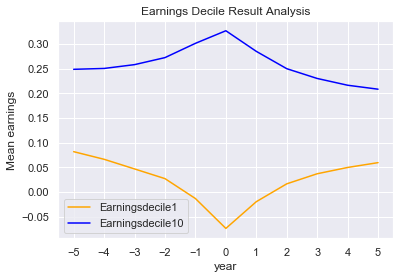

In [48]:
plt.title('Earnings Decile Result Analysis')

plt.plot(result_list['index'],result_list['Earningsdecile1'], color='orange', label='Earningsdecile1')
plt.plot(result_list['index'],result_list['Earningsdecile10'], color='blue', label='Earningsdecile10')
plt.xticks(np.arange(-5, 6, 1))
plt.legend()
plt.xlabel('year')
plt.ylabel('Mean earnings')
plt.show()

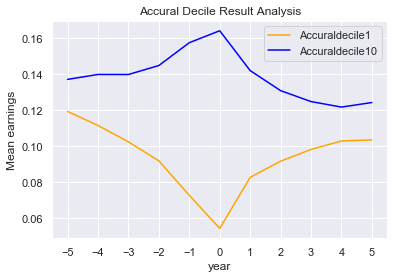

In [49]:
plt.title('Accural Decile Result Analysis')

plt.plot(result_list['index'],result_list['Accuraldecile1'], color='orange', label='Accuraldecile1')
plt.plot(result_list['index'],result_list['Accuraldecile10'], color='blue', label='Accuraldecile10')
plt.xticks(np.arange(-5, 6, 1))
plt.legend()
plt.xlabel('year')
plt.ylabel('Mean earnings')
plt.show()

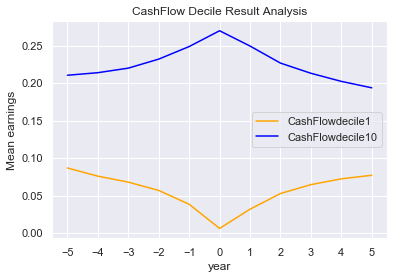

In [50]:
plt.title('CashFlow Decile Result Analysis')

plt.plot(result_list['index'],result_list['CashFlowdecile1'], color='orange', label='CashFlowdecile1')
plt.plot(result_list['index'],result_list['CashFlowdecile10'], color='blue', label='CashFlowdecile10')
plt.xticks(np.arange(-5, 6, 1))
plt.legend()
plt.xlabel('year')
plt.ylabel('Mean earnings')
plt.show()

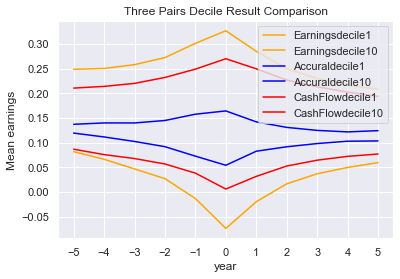

In [51]:
plt.title('Three Pairs Decile Result Comparison')

plt.plot(result_list['index'],result_list['Earningsdecile1'], color='orange', label='Earningsdecile1')
plt.plot(result_list['index'],result_list['Earningsdecile10'], color='orange', label='Earningsdecile10')
plt.plot(result_list['index'],result_list['Accuraldecile1'], color='blue', label='Accuraldecile1')
plt.plot(result_list['index'],result_list['Accuraldecile10'], color='blue', label='Accuraldecile10')
plt.plot(result_list['index'],result_list['CashFlowdecile1'], color='red', label='CashFlowdecile1')
plt.plot(result_list['index'],result_list['CashFlowdecile10'], color='red', label='CashFlowdecile10')

plt.xticks(np.arange(-5, 6, 1))
plt.legend()
plt.xlabel('year')
plt.ylabel('Mean earnings')
plt.show()